### To do


In [251]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, r2_score
from sklearn.metrics import auc, confusion_matrix, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.tree import DecisionTreeRegressor

### Loading the data

In [183]:
raw = pd.read_excel('data/dataframe_elections.xlsx')
print('Taille initiale du DF :', raw.shape)

# Données d'identification
id_list = ['an', 'dep', 'circo', 'code', 'nom', 'prenom', 'nuance', 'nuance_groupe', 'taux_vote_leg', 'second_tour']
df_id = raw[id_list]

# drop colonnes
drop_list = ['code', 'inscrits', 'circo_parti', 'circo_nuance',
             'nom', 'prenom', 'etiquette', 'nuance', 'voix', 'second_tour']
raw = raw.drop(drop_list, axis=1)

print('Taille du DF après retrait des colonnes inutiles :', raw.shape)

Taille initiale du DF : (36919, 83)
Taille du DF après retrait des colonnes inutiles : (36919, 73)


In [276]:
def generate_df(raw_data, keep_list, penalty=.8):
    # à garder obligatoirement pour identifier les lignes et créer les labels
    keep_list.extend(['an', 'c_dep', 'nuance_groupe', 'p_inscrits', 'p_exprimes'])

    df = raw_data.drop([col for col in raw_data.columns if col not in keep_list], axis=1)
    #print(df.columns)

    # Gestion des NaN au niveau du score du candidat aux législatives précédentes
    years = [2002, 2007, 2012, 2017]
    partis = ['EXG', 'COM', 'FI', 'DVG', 'ECO', 'SOC', 'RDG', 'MDM',
              'UDI', 'DVD', 'LR', 'DLF', 'FN', 'EXD', 'REG', 'DIV']
    
    # TODO : POUR LES CANDIDATS "EN MARCHE", PAR QUOI REMPLIR LE SCORE DES CANDIDATS A LA PREC LEG ?
    
    if 'score_candidat_prec_leg_ins' in keep_list:
        for parti in partis:
            #print('\nRemplissage des valeurs manquantes pour {} :'.format(parti))
            for year in years:
                mask = (df['an']==year) & (df['nuance_groupe']==parti)
                mask_2 = (df['an']==year - 5) & (df['nuance_groupe']==parti)
                mean = np.mean(df['p_inscrits'][mask_2]) * penalty # moyenne des voix du parti 5 ans avant (% d'inscrits)
                df.loc[mask, 'score_candidat_prec_leg_ins'] = df['score_candidat_prec_leg_ins'][mask].fillna(value=mean)
                #print('La moyenne du parti en {} est {:.2f}%'.format(year - 5, mean * 100))

        mean = np.mean(df.p_inscrits) * penalty
        df.score_candidat_prec_leg_ins = df.score_candidat_prec_leg_ins.fillna(value=mean)
        
    if 'score_candidat_prec_leg_expr' in keep_list:
        for parti in partis:
            #print('\nRemplissage des valeurs manquantes pour {} :'.format(parti))
            for year in years:
                mask = (df['an']==year) & (df['nuance_groupe']==parti)
                mask_2 = (df['an']==year - 5) & (df['nuance_groupe']==parti)
                mean = np.mean(df['p_exprimes'][mask_2]) * penalty # moyenne des voix du parti 5 ans avant (% exprimés)
                df.loc[mask, 'score_candidat_prec_leg_expr'] = df['score_candidat_prec_leg_expr'][mask].fillna(value=mean)
                #print('La moyenne du parti en {} est {:.2f}%'.format(year - 5, mean * 100))

        mean = np.mean(df.p_exprimes)
        df.score_candidat_prec_leg_expr = df.score_candidat_prec_leg_expr.fillna(value=mean)

    # Gestion des NaN : Autres variables. Remplacement des valeurs manquantes par la moyenne nationale
    features_a_completer = ['chom_tot', 'chom_jeunes', 'chom_adultes', 'chom_seniors',
                           'p_agri', 'p_commercants', 'p_cadres', 'p_intermed', 'p_employes',
                           'p_ouvriers', 'd_brevet', 'd_bep', 'd_bac', 'd_sup']
    for feature in features_a_completer:
        if feature in keep_list:
            #print('\nRemplissage des valeurs manquantes pour {} :'.format(feature))
            for year in years:
                mask = (df['an']==year)
                mean = np.mean(df[feature][mask])
                #print('La moyenne de la feature pour {} est {:.2f}%'.format(year, mean * 100))
                df.loc[mask, feature] = df[feature][mask].fillna(value=mean)

    # Catégorisation
    if 'score_candidat_prec_leg_cat' in keep_list:
        if 'score_candidat_prec_leg_expr' in keep_list:
            df['score_candidat_prec_leg_cat'] = pd.cut(df['score_candidat_prec_leg_expr'],
                                                       bins=[-1, -.01, .05, .1, .15, .25, 1],
                                                       labels=['N/A', 'A', 'B', 'C', 'D', 'E'])
        elif 'score_candidat_prec_leg_ins' in keep_list:
            df['score_candidat_prec_leg_cat'] = pd.cut(df['score_candidat_prec_leg_ins'],
                                                       bins=[-1, -.01, .05, .1, .15, .25, 1],
                                                       labels=['N/A', 'A', 'B', 'C', 'D', 'E'])

    df = df[df.an > 1997]
    #df = df[df.nuance_groupe!='DIV'] # On retire les candidats "Divers" (pour l'entraînement ET la prédiction)
    df = df[df.c_dep!=99] # Retrait des Français de l'Etranger
    
    df = df.drop('c_dep', axis=1)
    
    df = df.drop('nuance_groupe', axis=1)
    
    print('Format du dataframe :', df.shape)
    print(df.isnull().sum())
    
    return df

In [296]:
def train_val_splits(df, year_for_validation, target, scaler=MinMaxScaler()):
    # Liste des variables dummies et binaires pour les exclure de la normalisation
    dummies_list = ['bloc', 'sexe', 'an', 'p_inscrits', 'p_exprimes', 'dep', 'circo',
                    'geo_frontalier', 'geo_dom', 'geo_idf',
                    'circo_nuance_groupe', 'circo_bloc', 'nuance_groupe',
                    'circo_nuance_groupe_pres', 'circo_pres_meme_nuance', 'circo_meme_nuance_president',
                    'circo_leg_meme_nuance',
                    'depute_sortant', 'ancien_depute', 'au_gouvernement', 'ancien_ministre', 'membre_majorite',
                    'nb_candidats_meme_bloc', 'nb_candidats_circo',
                    'score_candidat_prec_leg_cat',
                    'score_candidat_prec_leg_expr', 'score_candidat_prec_leg_ins',
                    'nb_acces_second_tour'
                   ]
    scale_list = [col for col in df.columns if col not in dummies_list]

    df = pd.get_dummies(df, drop_first=True)
    
    drop_list = ['an', 'p_inscrits', 'p_exprimes']
    df_train = df[(df.an != 2017) & (df.an != year_for_validation)].dropna(how='any')
    y_train = df_train[target]
    X_train = df_train.drop(drop_list, axis=1)
    
    df_val = df[df.an == year_for_validation].dropna(how='any')
    y_val = df_val[target]
    X_val = df_val.drop(drop_list, axis=1)
    
    # Normalisation du dataframe
    if scaler:
        print('Variables à normaliser', scale_list)
        X_train[scale_list] = scaler.fit_transform(X_train[scale_list])
        X_val[scale_list] = scaler.transform(X_val[scale_list])

    print('Format des ensembles de train et de validation :')
    print(X_train.shape, X_val.shape)
    
    return X_train, X_val, y_train, y_val

In [297]:
def get_classif(y_pred, y_val, id_val, target, strategy):
    from scipy.stats import rankdata
    
    res = pd.concat([id_val, pd.DataFrame(y_val)], axis=1, join='inner')
    res['prediction'] = y_pred
    res['classement'] = 0
    res['qualif'] = 'N'
    
    for circo in set(res.code):
        # classement des candidats par circonscription
        res.loc[res.code==circo, 'classement'] = rankdata(-res.prediction[res.code==circo], method='ordinal')
        
        # normalisation des votes pour que la somme soit égale à 100%
        res.loc[res.code==circo, 'prediction'] /= np.sum(res.loc[res.code==circo, 'prediction'])
        
        if target=='p_exprimes':
            taux_E = 1
            taux_O = np.float(res.loc[(res.code==circo) & (res.classement==1), 'taux_vote_leg'])
        elif target=='p_inscrits':
            taux_E = 1 / np.float(res.loc[(res.code==circo) & (res.classement==1), 'taux_vote_leg'])
            taux_O = 1
            
        # simulation des qualifiés pour le second tour
        i = 1
        q = 0
        while True:
            #print(res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values)
            if (res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values) * taux_E >= .5:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'E'
                if strategy == 'O':
                    q += 1
                elif strategy == 'E':
                    break
            elif (res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values) * taux_O >= .125:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'O'
                q += 1
            elif q < 2:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'O'
                q += 1
            else:
                break

            i += 1
        
    res['ecart'] = res['prediction'] - res[target]
    
    return res

In [298]:
def analyze_predictions(df_predictions, target):
    n = df_predictions.shape[0]
    print('Prédictions pour {} candidats.'.format(n))

    ecarts_absolus = abs(df_predictions.ecart)
    max_ecart = np.max(ecarts_absolus)
    grid = np.arange(max_ecart, step=.01)
    ecarts_grid = []

    for point in grid:
        ecarts_grid.append(np.sum(ecarts_absolus < point))

    print('La MAE est : {:.2f}%'.format(
            mean_absolute_error(df_predictions[target], df_predictions.prediction) * 100))
    print('La plus grosse erreur est : {:.2f}%'.format(max_ecart * 100))
    print('Le score r2 est : {:.2f}'.format(r2_score(df_predictions[target], df_predictions.prediction)))

    point_list = [.01, .02, .05, .1]
    ecart_list = [np.sum(ecarts_absolus < point) for point in point_list]

    plt.figure(1, figsize=(13, 3))
    plt.subplot(121)
    plt.plot(grid, ecarts_grid)
    for i in range(len(point_list)):
        plt.plot(point_list[i], ecart_list[i], 'ro')
        plt.text(point_list[i]+.005, ecart_list[i]-400, '{:.2f}%'.format(ecart_list[i]/n))

    plt.title('Nb d\'obs en dessous d\'un seuil d\'erreur')
    plt.xlabel('Seuils d\'erreur')

    plt.subplot(122)
    plt.hist(df_predictions['ecart'], bins=50)
    plt.title('Répartition globale des erreurs')

    # comparaison de la distribution des erreurs, parti par parti
    from scipy.stats import gaussian_kde
    plt.figure(2, figsize=(15,4))
    x_grid = np.arange(min(df_predictions['ecart']), max(df_predictions['ecart']), step=.01)
    
    nuances = {'FI': 'red','ECO': 'green', 'SOC': 'pink', 'RDG': 'grey', 'MDM': 'orange', 'UDI': 'yellow',
               'LR': 'blue', 'DLF': 'darkblue', 'FN': 'black', 'REG': 'teal'}
    for nuance in nuances:
        n_pred = df_predictions[(df_predictions['nuance_groupe']==nuance)
                                & ((df_predictions['qualif']=='E')
                               | (df_predictions['qualif']=='O'))].shape[0]
        n_reel = df_predictions[(df_predictions['nuance_groupe']==nuance)
                                & ((df_predictions['second_tour']=='E')
                               | (df_predictions['second_tour']=='O'))].shape[0]
        print('{}: {} prédits | Réel {}'.format(nuance, n_pred, n_reel))
        try: # cas où le parti n'est pas représenté à l'élection prédite
            pdf = gaussian_kde(df_predictions['ecart'][df_predictions['nuance_groupe']==nuance],
                               bw_method=.9).evaluate(x_grid)
            plt.plot(x_grid, pdf, color=nuances[nuance], label=nuance, lw=2)
        except:
            pass

    plt.title('Répartition des erreurs selon le parti')
    plt.legend(loc='best')

    n_correct = np.sum(df_predictions.second_tour == df_predictions.qualif)
    print('\n{} prédictions correctes sur {} (soit {:.1f}%)'.format(n_correct, n, 100 * n_correct / n))

    print('\nMatrice de confusion. En colonne les classes prédites, en ligne les classes réelles.')
    cm = confusion_matrix(df_predictions.second_tour, df_predictions.qualif, labels=['E', 'O', 'N'])
    print(cm)

    f1_E = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='E', average='micro')
    print('Score F1 pour la classe E : {:.1f}%'.format(f1_E * 100))
    f1_O = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='O', average='micro')
    print('Score F1 pour la classe O : {:.1f}%'.format(f1_O * 100))
    f1_N = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='N', average='micro')
    print('Score F1 pour la classe N : {:.1f}%'.format(f1_N * 100))
    plt.show()
    
    return

### Choix des paramètres

In [299]:
# Sélection des features
keep_list = ['geo_frontalier', 'geo_dom', 'geo_idf',
    'part_impose', 
    'chom_tot',
    'revenus_q1', 'revenus_med', 'revenus_q3', 'ecart_revenus',
    'chom_jeunes', 'chom_adultes', 'chom_seniors',
    'p_agri', 'p_commercants', 'p_cadres', 'p_intermed', 'p_employes',
    'p_ouvriers', 'd_brevet', 'd_bep', 'd_bac', 'd_sup'
    'circo_leg_meme_nuance', 'circo_pres_meme_nuance', 'circo_meme_nuance_president',
    'nb_candidats_meme_bloc',
    'nb_candidats_circo',
    'score_nuance_groupe_pres', 'score_bloc_pres',
    #'score_candidat_prec_leg_ins',
    #'score_candidat_prec_leg_expr',
    #'score_candidat_prec_leg_cat',
    #'score_nuance_groupe_prec_leg', #(un peu mauvais)
    #'score_bloc_prec_leg', #(mauvais pour le score)
    #'nuance_groupe',
    'taux_vote_pres', #'taux_vote_leg',
    'depute_sortant', 'ancien_depute', 'au_gouvernement', 'ancien_ministre', 'membre_majorite',
    'nb_acces_second_tour',
    'sexe', 'dep', 'circo'
]

scaler = MinMaxScaler()
#scaler = StandardScaler()

# Prédire les score en % des voix exprimées ou % des inscrits sur les listes électorales
target_values = 'p_exprimes' # 'p_inscrits'
target_year = 2012

# Taux par lequel on multiplie les score à la législative précédente qui étaient à la base des N/A
penalty = .9

# si 'O' : on note les potentiels qualifiés dès le 1er tour mais on indique aussi le candidat arrivé 2ème
# si 'E' : si un candidat est classé 'E', ses concurrents sont automatiquement tous classés 'N'
strategy = 'O' 

In [300]:
df = generate_df(raw, keep_list, penalty=penalty)
X_train, X_val, y_train, y_val = train_val_splits(df, target_year, target_values, scaler)

Format du dataframe : (30205, 40)
an                                0
dep                               0
circo                             0
geo_frontalier                    0
geo_dom                           0
geo_idf                           0
part_impose                       0
revenus_q1                        0
revenus_med                       0
revenus_q3                        0
ecart_revenus                     0
chom_tot                          0
chom_jeunes                       0
chom_adultes                      0
chom_seniors                      0
p_agri                            0
p_commercants                     0
p_cadres                          0
p_intermed                        0
p_employes                        0
p_ouvriers                        0
d_brevet                          0
d_bep                             0
d_bac                             0
circo_pres_meme_nuance            0
circo_meme_nuance_president       0
score_nuance_groupe_pres      

In [301]:
X_train.head(2)

,circo,geo_frontalier,geo_dom,geo_idf,part_impose,revenus_q1,revenus_med,revenus_q3,ecart_revenus,chom_tot,...,dep_VAL-DE-MARNE,dep_VAR,dep_VAUCLUSE,dep_VENDEE,dep_VIENNE,dep_VOSGES,dep_WALLIS-ET-FUTUNA,dep_YONNE,dep_YVELINES,sexe_M
14488,1,1,0,0,0.546669,0.512791,0.363924,0.236599,0.177559,0.061475,...,0,0,0,0,0,0,0,0,0,1
14489,1,1,0,0,0.546669,0.512791,0.363924,0.236599,0.177559,0.061475,...,0,0,0,0,0,0,0,0,0,1


### Factorisation de la matrice des départements dummisés

In [283]:
departs = pd.DataFrame()
for col in X_train:
    if "dep_" in col:
        departs = pd.concat([departs, X_train[col]], axis=1)
        X_train.drop(col, axis=1, inplace=True)

In [192]:
departs_val = pd.DataFrame()
for col in X_val:
    if "dep_" in col:
        departs_val = pd.concat([departs_val, X_val[col]], axis=1)
        X_val.drop(col, axis=1, inplace=True)

In [131]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA

model = NMF(n_components=10, init='random', random_state=0)
model = PCA(n_components=10)
new_departs = pd.DataFrame(model.fit_transform(departs))

In [136]:
#X_train = pd.concat([X_train, new_departs], axis=1)
#X_val = pd.concat([X_val, pd.DataFrame(model.transform(departs_val))], axis=1)

### Choix de modèle

In [328]:
np.shape(pred_array)

(2,)

### On stock les predictions pour un sgd 

In [387]:
pred_array_train = np.zeros([y_train.shape[0], 5])
pred_array_val = np.zeros([y_val.shape[0], 5])

### Random Forest 

In [388]:
from sklearn.ensemble import RandomForestRegressor
#rf = make_pipeline(PCA(), RandomForestRegressor(n_jobs=-1, n_estimators=100))
rf = RandomForestRegressor(n_jobs=-1, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
sorted(list(zip(rf.feature_importances_, X_train.columns)), reverse=True)

[(0.25955499695093204, 'nb_acces_second_tour'),
 (0.22126180577104271, 'score_nuance_groupe_pres'),
 (0.18659875838289819, 'ancien_depute'),
 (0.13423782721229055, 'membre_majorite'),
 (0.062677594832031724, 'score_bloc_pres'),
 (0.024531966153179052, 'depute_sortant'),
 (0.013315646469489486, 'nb_candidats_meme_bloc'),
 (0.010934317333890694, 'taux_vote_pres'),
 (0.0059802018138576697, 'nb_candidats_circo'),
 (0.0054196260620552284, 'ecart_revenus'),
 (0.0046708028671201751, 'revenus_q1'),
 (0.0041260728871747414, 'd_bac'),
 (0.0041222806338627599, 'circo'),
 (0.0039780595894589156, 'd_brevet'),
 (0.0039466012905794209, 'part_impose'),
 (0.0035477627578027787, 'revenus_q3'),
 (0.0033867330656840383, 'sexe_M'),
 (0.0033566847799425879, 'revenus_med'),
 (0.0031032193230515715, 'chom_jeunes'),
 (0.0030031059775520179, 'p_employes'),
 (0.0029962993350477248, 'p_agri'),
 (0.0028552999502568089, 'p_commercants'),
 (0.0028049994482616269, 'd_bep'),
 (0.0026774770097453653, 'chom_adultes'),
 

In [389]:
sfm = SelectFromModel(estimator=rf, prefit=True, threshold=0.0001)
temp_tr = sfm.transform(X_train)
temp_te = sfm.transform(X_val)

In [390]:
temp_tr.shape

(16077, 87)

In [391]:
#rf = make_pipeline(PCA(), RandomForestRegressor(n_jobs=-1, n_estimators=100))
rf = RandomForestRegressor(n_jobs=-1, n_estimators=100)
rf.fit(temp_tr, y_train)

pred_array_train[:, 0] = rf.predict(temp_tr)
pred_array_val[:, 0] = rf.predict(temp_te)

### XGBoost

In [392]:
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
clf = XGBRegressor(max_depth=3)
clf.fit(temp_tr, y_train)
mean_absolute_error(clf.predict(temp_te), y_val)

0.034028067246223613

In [409]:
pred_array_train[:, 1] = clf.predict(temp_tr)
pred_array_val[:, 1] = clf.predict(temp_te)

Prédictions pour 6429 candidats.
La MAE est : 3.47%
La plus grosse erreur est : 39.09%
Le score r2 est : 0.82
UDI: 31 prédits | Réel 45
SOC: 459 prédits | Réel 427
ECO: 9 prédits | Réel 44
RDG: 14 prédits | Réel 28
MDM: 11 prédits | Réel 12
DLF: 1 prédits | Réel 1
FI: 34 prédits | Réel 12
FN: 109 prédits | Réel 59
REG: 1 prédits | Réel 4
LR: 438 prédits | Réel 422

5974 prédictions correctes sur 6429 (soit 92.9%)

Matrice de confusion. En colonne les classes prédites, en ligne les classes réelles.
[[  20   16    0]
 [  70  840  169]
 [   0  200 5114]]
Score F1 pour la classe E : 31.7%
Score F1 pour la classe O : 78.7%
Score F1 pour la classe N : 96.5%


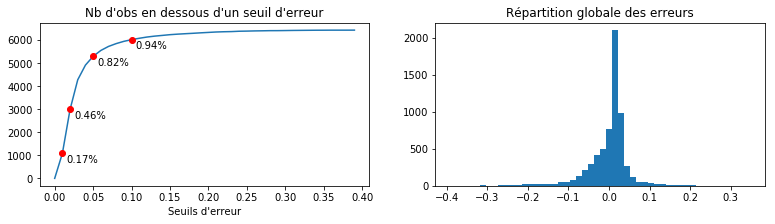

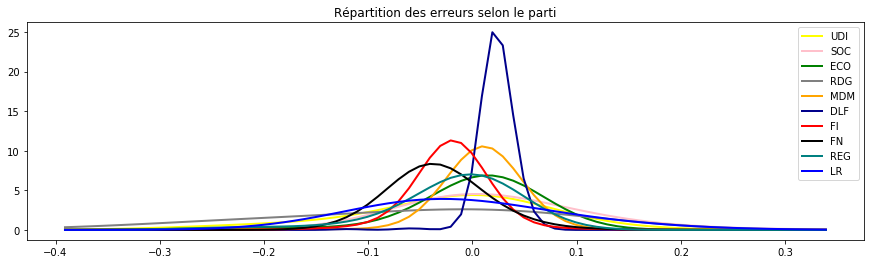

In [322]:
df_predictions = get_classif(clf.predict(temp_te), y_val, df_id, target_values, strategy)
analyze_predictions(df_predictions, target_values)

In [176]:
from xgboost import XGBRegressor

clf = XGBRegressor()
param_grid = {'n_estimators': [75, 100, 125], #140, 150, 160: 160
              'max_depth' : [2, 3, 4, 5, 6, 7], #70
              "learning_rate" : [0.01, 0.05, 0.1, 0.2, 0.3], #0.05, 0.1, 0.2 : 0.05
              'reg_alpha' : [0.5, 0.75, 1, 1.25, 1.5, 2, 3], #8, 10, 12 : 8
              'reg_lambda' : [0, 0.25, 0.5, 0.75, 1, 2, 2], #.7
             }

rs = RandomizedSearchCV(clf, param_grid, cv=4, n_jobs=2, scoring=make_scorer(mean_absolute_error))
rs.fit(temp_tr, y_train)

clf = rs.best_estimator_
clf.fit(temp_tr, y_train)
mean_absolute_error(clf.predict(temp_te), y_val)

KeyboardInterrupt: 

### KNN

In [114]:
from sklearn.neighbors import KNeighborsRegressor
for i in range(2, 10):
    reg = KNeighborsRegressor(n_neighbors=i, weights='distance', n_jobs=-1)
    reg.fit(X_train, y_train)
    y_pred_knn = reg.predict(X_val)
    print('{} voisins : {:.2f}%'.format(i, 100 * mean_absolute_error(y_pred_knn, y_val)))

2 voisins : 4.24%
3 voisins : 4.15%
4 voisins : 4.10%
5 voisins : 4.08%
6 voisins : 4.07%
7 voisins : 4.07%
8 voisins : 4.08%
9 voisins : 4.07%


In [397]:
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor(n_neighbors=6, weights='distance', n_jobs=-1)
reg.fit(temp_tr, y_train)
pred_array_train[:, 2] = reg.predict(temp_tr)
pred_array_val[:, 2] = reg.predict(temp_te)

### MLPRegressor

In [403]:
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor((5, 5, 5), activation='relu', solver='adam', alpha=1e-4, batch_size=200,
                   learning_rate='constant', learning_rate_init=1e-3, max_iter=500, tol=1e-7, verbose=True,
                  power_t=.5, early_stopping=False)
reg.fit(temp_tr, y_train)

Iteration 1, loss = 0.10321630
Iteration 2, loss = 0.00780414
Iteration 3, loss = 0.00666692
Iteration 4, loss = 0.00459411
Iteration 5, loss = 0.00305719
Iteration 6, loss = 0.00265352
Iteration 7, loss = 0.00233430
Iteration 8, loss = 0.00207300
Iteration 9, loss = 0.00185979
Iteration 10, loss = 0.00170848
Iteration 11, loss = 0.00160981
Iteration 12, loss = 0.00155286
Iteration 13, loss = 0.00147636
Iteration 14, loss = 0.00145271
Iteration 15, loss = 0.00141356
Iteration 16, loss = 0.00139290
Iteration 17, loss = 0.00137629
Iteration 18, loss = 0.00135100
Iteration 19, loss = 0.00133408
Iteration 20, loss = 0.00132606
Iteration 21, loss = 0.00132558
Iteration 22, loss = 0.00131055
Iteration 23, loss = 0.00131459
Iteration 24, loss = 0.00131051
Iteration 25, loss = 0.00129553
Iteration 26, loss = 0.00130069
Iteration 27, loss = 0.00127953
Iteration 28, loss = 0.00129102
Iteration 29, loss = 0.00127324
Iteration 30, loss = 0.00127792
Iteration 31, loss = 0.00126518
Iteration 32, los

MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 5, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=1e-07, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [404]:
mean_absolute_error(reg.predict(temp_te), y_val)

0.033623665158664218

Prédictions pour 6429 candidats.
La MAE est : 3.67%
La plus grosse erreur est : 51.66%
Le score r2 est : 0.79
UDI: 31 prédits | Réel 45
SOC: 459 prédits | Réel 427
ECO: 11 prédits | Réel 44
RDG: 13 prédits | Réel 28
MDM: 11 prédits | Réel 12
DLF: 2 prédits | Réel 1
FI: 29 prédits | Réel 12
FN: 120 prédits | Réel 59
REG: 1 prédits | Réel 4
LR: 436 prédits | Réel 422

5931 prédictions correctes sur 6429 (soit 92.3%)

Matrice de confusion. En colonne les classes prédites, en ligne les classes réelles.
[[  22   14    0]
 [ 112  795  172]
 [   3  197 5114]]
Score F1 pour la classe E : 25.4%
Score F1 pour la classe O : 76.3%
Score F1 pour la classe N : 96.5%


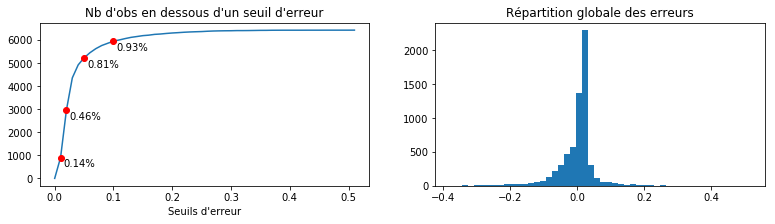

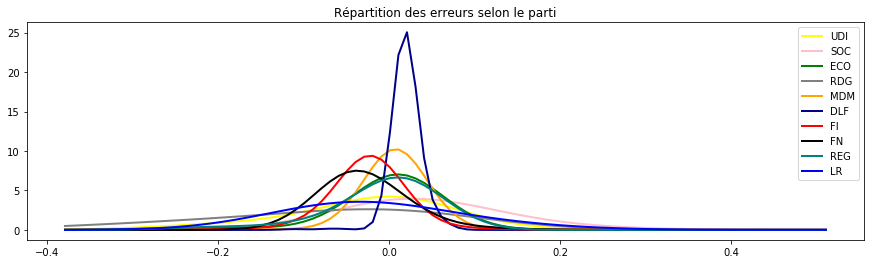

In [373]:
df_predictions = get_classif(reg.predict(temp_te), y_val, df_id, target_values, strategy)
analyze_predictions(df_predictions, target_values)

In [405]:
pred_array_train[:, 3] = reg.predict(temp_tr)
pred_array_val[:, 3] = reg.predict(temp_te)

In [415]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf', C=)
svr.fit(temp_tr, y_train)
print(mean_absolute_error(svr.predict(temp_te), y_val))
pred_array_train[:, 4] = reg.predict(temp_tr)
pred_array_val[:, 4] = reg.predict(temp_te)

0.0717589337128


### Boosting des modèles

** Mean : **

In [115]:
# Mix des prédictions des modèles
y_pred = np.mean(np.array([y_pred_rf,
                           y_pred_knn,
                          y_pred_mlp
                          ]), axis=0)

Prédictions pour 6024 candidats.
La MAE est : 3.76%
La plus grosse erreur est : 40.33%
Le score r2 est : 0.77
FN: 80 prédits | Réel 59
RDG: 17 prédits | Réel 28
FI: 24 prédits | Réel 12
LR: 464 prédits | Réel 422
MDM: 13 prédits | Réel 12
UDI: 31 prédits | Réel 45
SOC: 457 prédits | Réel 427
REG: 1 prédits | Réel 4
ECO: 13 prédits | Réel 44
DLF: 1 prédits | Réel 1

5545 prédictions correctes sur 6024 (soit 92.0%)

Matrice de confusion. En colonne les classes prédites, en ligne les classes réelles.
[[  22   14    0]
 [ 116  801  162]
 [   0  187 4722]]
Score F1 pour la classe E : 25.3%
Score F1 pour la classe O : 77.0%
Score F1 pour la classe N : 96.4%


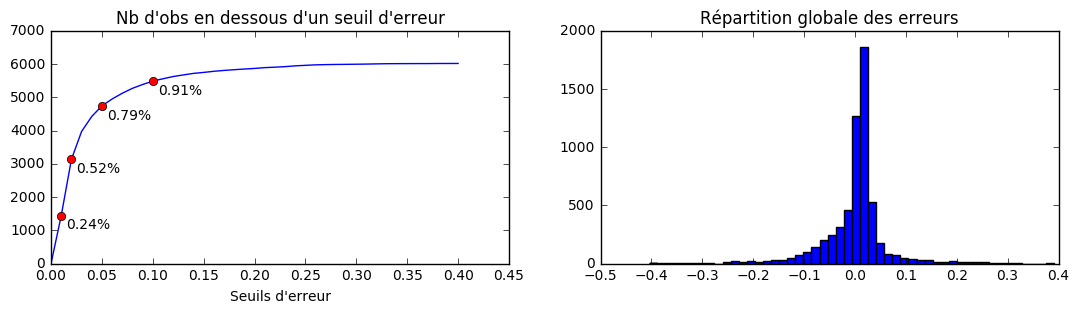

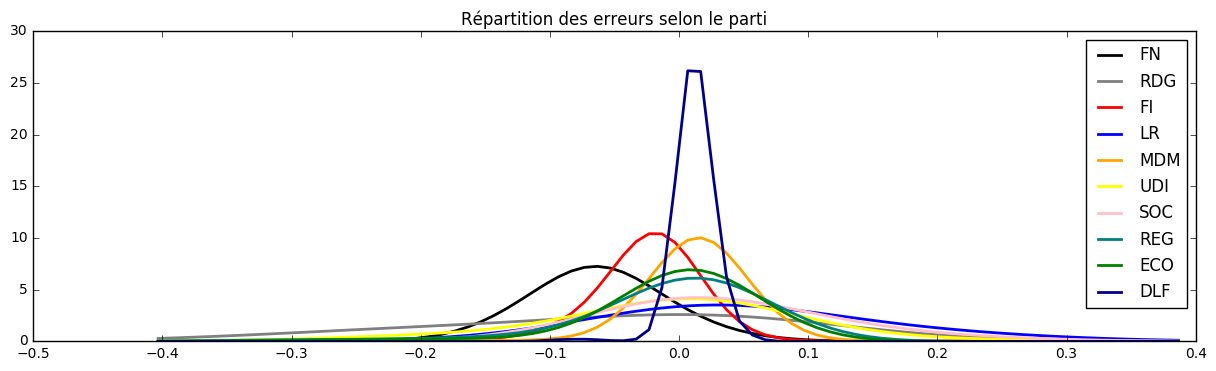

In [116]:
df_predictions = get_classif(y_pred_rf, y_val, df_id, target_values, strategy)
analyze_predictions(df_predictions, target_values)

** SGD : 
**

In [358]:
from sklearn.linear_model import SGDRegressor

In [406]:
sgd = SGDRegressor(loss='squared_loss')
sgd.fit(pred_array_train, y_train)
mean_absolute_error(sgd.predict(pred_array_val), y_val)

0.039413562342895003

In [407]:
sgd.coef_

array([ 0.25677713,  0.25677713,  0.27605962,  0.2059355 ,  0.        ])

Prédictions pour 6429 candidats.
La MAE est : 3.92%
La plus grosse erreur est : 40.32%
Le score r2 est : 0.80
UDI: 31 prédits | Réel 45
SOC: 456 prédits | Réel 427
ECO: 9 prédits | Réel 44
RDG: 14 prédits | Réel 28
MDM: 10 prédits | Réel 12
DLF: 1 prédits | Réel 1
FI: 34 prédits | Réel 12
FN: 97 prédits | Réel 59
REG: 2 prédits | Réel 4
LR: 437 prédits | Réel 422

5996 prédictions correctes sur 6429 (soit 93.3%)

Matrice de confusion. En colonne les classes prédites, en ligne les classes réelles.
[[  15   21    0]
 [  49  858  172]
 [   0  191 5123]]
Score F1 pour la classe E : 30.0%
Score F1 pour la classe O : 79.9%
Score F1 pour la classe N : 96.6%


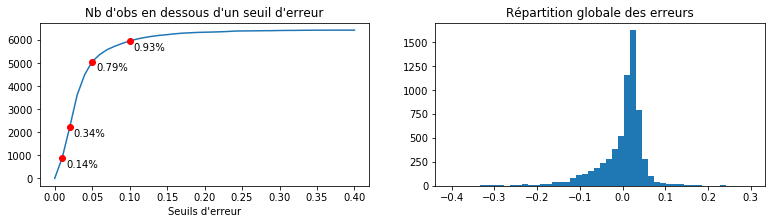

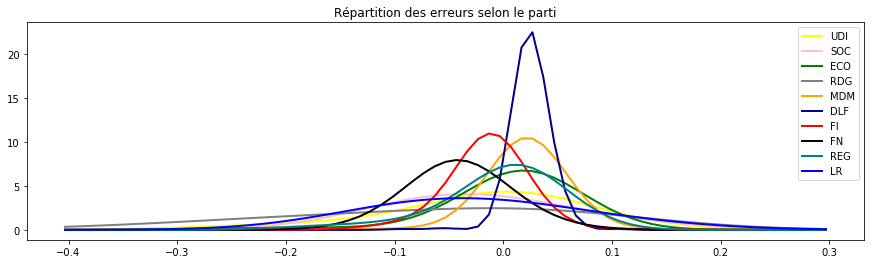

In [408]:
df_predictions = get_classif(sgd.predict(pred_array_val), y_val, df_id, target_values, strategy)
analyze_predictions(df_predictions, target_values)

### Analyses 

In [591]:
df_predictions.sort_values(by='ecart').head(3)

,an,dep,circo,code,nom,prenom,nuance_groupe,taux_vote_leg,second_tour,p_exprimes,prediction,classement,qualif,ecart
13113,2012,SAINT-PIERRE-ET-MIQUELON,1,975|1,GIRARDIN,ANNICK,RDG,0.5186,E,0.6552,0.096528,4,N,-0.558672
10982,2012,LA-REUNION,2,974|2,BELLO,HUGUETTE,DVG,0.4562,E,0.6712,0.221551,2,O,-0.449649
12340,2012,PARIS,6,75|6,DUFLOT,CECILE,ECO,0.5929,O,0.4874,0.064594,4,N,-0.422806


In [592]:
df_predictions.sort_values(by='ecart').tail(3)

,an,dep,circo,code,nom,prenom,nuance_groupe,taux_vote_leg,second_tour,p_exprimes,prediction,classement,qualif,ecart
8653,2012,CALVADOS,5,14|5,NOUVELOT,CEDRIC,LR,0.5970,O,0.2402,0.555583,1,E,0.315383
9452,2012,FRANCAIS-DE-L'ETRANGER,2,99|2,DROUHAUD,PASCAL,LR,0.1573,O,0.2276,0.548723,1,E,0.321123
13116,2012,SAINT-PIERRE-ET-MIQUELON,1,975|1,ZIMMERMANN,FRANCOIS,LR,0.5186,N,0.1132,0.442358,1,O,0.329158


#### Save predictions

In [318]:
from datetime import datetime
now = datetime.now()
stamp = '{}_{}_{}h{}'.format(now.day, now.month, now.hour, now.minute)
df_predictions.to_excel('predictions_du_{}.xlsx'.format(stamp))

In [ ]:
#todo : utiliser nuance et pas nuance groupe
exportCsv = df_predictions[['code','prenom','nom','nuance_groupe','prediction','qualif']]
exportCsv['code'] = exportCsv['code'].apply(str.lower)
exportCsv['code'] = exportCsv['code'].apply(lambda x : x.replace('|', '-'))
exportCsv['candidat'] = exportCsv['prenom'] + ' ' + exportCsv['nom']


exportCsv1 = exportCsv[exportCsv['qualif'] == 'O']
vainqueurs1er = exportCsv[exportCsv['qualif'] == 'E']

exportCsv1 = exportCsv1.drop(['prenom','nom','qualif'], axis=1)
exportCsv1 = exportCsv1.sort_values(['code', 'prediction'], ascending=[True, False])

circos = exportCsv1['code'].unique()
temp = pd.DataFrame()
d = {}
for c in circos:
    temp = exportCsv1[exportCsv1['code'] == c]
    l = []
    for index, rows in temp.iterrows():
        l.extend(rows[1:].values)
    d[c] = l

duels = {k: v for k, v in d.items() if len(v) < 7}
triangulaires = {k: v for k, v in d.items() if len(v) > 6 and len(v) < 10}
quadrangulaires = {k: v for k, v in d.items() if len(v) > 10}

duels = pd.DataFrame(duels)
duels.index = ['color1','score1','candidat1','color2','score2','candidat2']
duels = duels.T
#duels['color3'],duels['score3'],duels['candidat3'],duels['color4'],duels['score4'],duels['candidat4'] = '','','','','',''
print(duels.head())

triangulaires = pd.DataFrame(triangulaires)
triangulaires.index = ['color1','score1','candidat1','color2','score2','candidat2','color3','score3','candidat3']
triangulaires = triangulaires.T
#triangulaires['color4'], triangulaires['score4'], triangulaires['candidat4'] = '','',''

print(triangulaires.head())

quadrangulaires = pd.DataFrame(quadrangulaires)
quadrangulaires.index = ['color1','score1','candidat1','color2','score2','candidat2','color3',
                         'score3','candidat3','color4','score4','candidat4']
quadrangulaires = quadrangulaires.T
print(quadrangulaires.head())

vainqueurs1er.index = vainqueurs1er.code
vainqueurs1er = vainqueurs1er.drop(['code','prenom','nom','qualif'], axis=1)
vainqueurs1er['color1'], vainqueurs1er['score1'], vainqueurs1er['candidat1'] = vainqueurs1er.nuance_groupe,\
vainqueurs1er.prediction, vainqueurs1er.candidat
vainqueurs1er = vainqueurs1er.drop(['nuance_groupe', 'prediction', 'candidat'], axis=1)
print(vainqueurs1er.head())


final = pd.concat([vainqueurs1er, duels, triangulaires, quadrangulaires])
final = final.fillna(value='')
final.index.name = 'circo'
final['nom circo'] = 'Davy Champion'
print(final.head())
final.to_csv('dataviz/data/resultats1.csv', index=True)